In [1]:
import pprint
import time
from pathlib import Path

import lightgbm as lgb
import numpy as np
import pandas as pd
import seaborn as sns
from hydra import compose, initialize
from matplotlib import pyplot as plt
from omegaconf import OmegaConf
from sklearn.model_selection import GroupKFold

from src.seed import seed_everything

with initialize(config_path="config", version_base=None):
    cfg = compose(config_name="config")
    cfg.exp_number = Path().resolve().name

print(OmegaConf.to_yaml(cfg, resolve=True))

seed_everything(cfg.seed)


lgb:
  params:
    objective: regression
    metric: rmse
    verbose: -1
    boosting_type: gbdt
    learning_rate: 0.05
    num_leaves: 31
    min_child_samples: 20
    max_depth: -1
    subsample_freq: 0
    bagging_seed: 0
    feature_fraction: 0.9
    bagging_fraction: 0.8
    reg_alpha: 0.1
    reg_lambda: 0.1
    seed: 42
  early_stopping_rounds: 100
  log_evaluation: 100
  num_boost_round: 10000000
exp_number: '001'
run_name: base
data:
  data_root: ../../data
  results_root: ../../results
  train_path: ../../data/train.csv
  anime_path: ../../data/anime.csv
  test_path: ../../data/test.csv
  sample_submission_path: ../../data/sample_submission.csv
  results_dir: ../../results/001/base
seed: 42
n_splits: 5
target: score



### Import

In [2]:
train_df = pd.read_csv(cfg.data.train_path)
anime_df = pd.read_csv(cfg.data.anime_path)
test_df = pd.read_csv(cfg.data.test_path)

train_df = train_df.merge(anime_df, how="left", on="anime_id")
test_df = test_df.merge(anime_df, how="left", on="anime_id")
all_df = pd.concat([train_df, test_df])

features = [col for col in train_df.columns if col != cfg.target]
num_features = train_df[features].select_dtypes(exclude="object").columns.tolist()
cat_features = train_df[features].select_dtypes(include="object").columns.tolist()


### 特徴量加工

In [3]:
# CountEncoding. all_dfで集計していることに注意
for col in cat_features:
    count_map = all_df[col].value_counts()
    train_df[f"count_{col}"] = train_df[col].map(count_map)
    test_df[f"count_{col}"] = test_df[col].map(count_map)

# GroupbyEncoding. all_dfで集計していることに注意
methods = ["mean", "std", "min", "max", "median"]
for grp_col in cat_features:
    grp_df = all_df.groupby(grp_col)[num_features].agg(methods).reset_index()
    grp_df.columns = [grp_col] + [f"grpby_{grp_col}_{col}_{m}" for m in methods for col in num_features]
    train_df = train_df.merge(grp_df, how="left", on=grp_col)
    test_df = test_df.merge(grp_df, how="left", on=grp_col)

# CategoryEncoding
for col in cat_features:
    train_df[col] = train_df[col].astype("category")
    test_df[col] = test_df[col].astype("category")


### 学習

In [4]:
x_train = train_df.drop([cfg.target, "user_id"], axis=1)
y_train = train_df[cfg.target]
groups = train_df["user_id"]
kf = GroupKFold(n_splits=cfg.n_splits)

# 実験結果格納用のディレクトリを作成
cfg.run_name = time.strftime("%Y%m%d_%H%M%S")
Path(cfg.data.results_dir).mkdir(exist_ok=True, parents=True)

# 学習設定
lgb_data = lgb.Dataset(
    x_train,
    label=y_train,
    categorical_feature=x_train.select_dtypes(include=["category"]).columns.tolist(),
    free_raw_data=True,
)
callbacks=[
    lgb.early_stopping(stopping_rounds=cfg.lgb.early_stopping_rounds),
    lgb.log_evaluation(cfg.lgb.log_evaluation),
]

# 学習
cv_results = lgb.cv(
    dict(cfg.lgb.params),
    lgb_data,
    folds=kf.split(x_train, y_train, groups=groups),
    num_boost_round=cfg.lgb.num_boost_round,
    callbacks=callbacks,
    return_cvbooster=True,
    stratified=False,
    seed=cfg.seed,
)

# 学習モデル保存
cvbooster = cv_results["cvbooster"]
cvbooster.save_model(f"{cfg.data.results_dir}/model.pkl")


Training until validation scores don't improve for 100 rounds
[100]	cv_agg's valid rmse: 1.40618 + 0.0207614
Early stopping, best iteration is:
[86]	cv_agg's valid rmse: 1.40584 + 0.0204323


### log

In [9]:
best_iteration = cvbooster.best_iteration
best_score = cv_results["valid rmse-mean"][best_iteration - 1]
best_score_stdv = cv_results["valid rmse-stdv"][best_iteration - 1]

with open(f"{cfg.data.results_dir}/log.txt", "w") as log_file:
    log_file.write("====== CV Score ======\n")
    log_file.write(f"best_iteration: {best_iteration}\n")
    log_file.write(f"best_score: {best_score}\n")
    log_file.write(f"best_score_stdv: {best_score_stdv}\n")

    log_file.write("\n====== params ======\n")
    log_file.write(OmegaConf.to_yaml(cfg, resolve=True))

    log_file.write("\n====== feature name ======\n")
    log_file.write(pprint.pformat(cvbooster.feature_name()[0]))


### Feature Importance

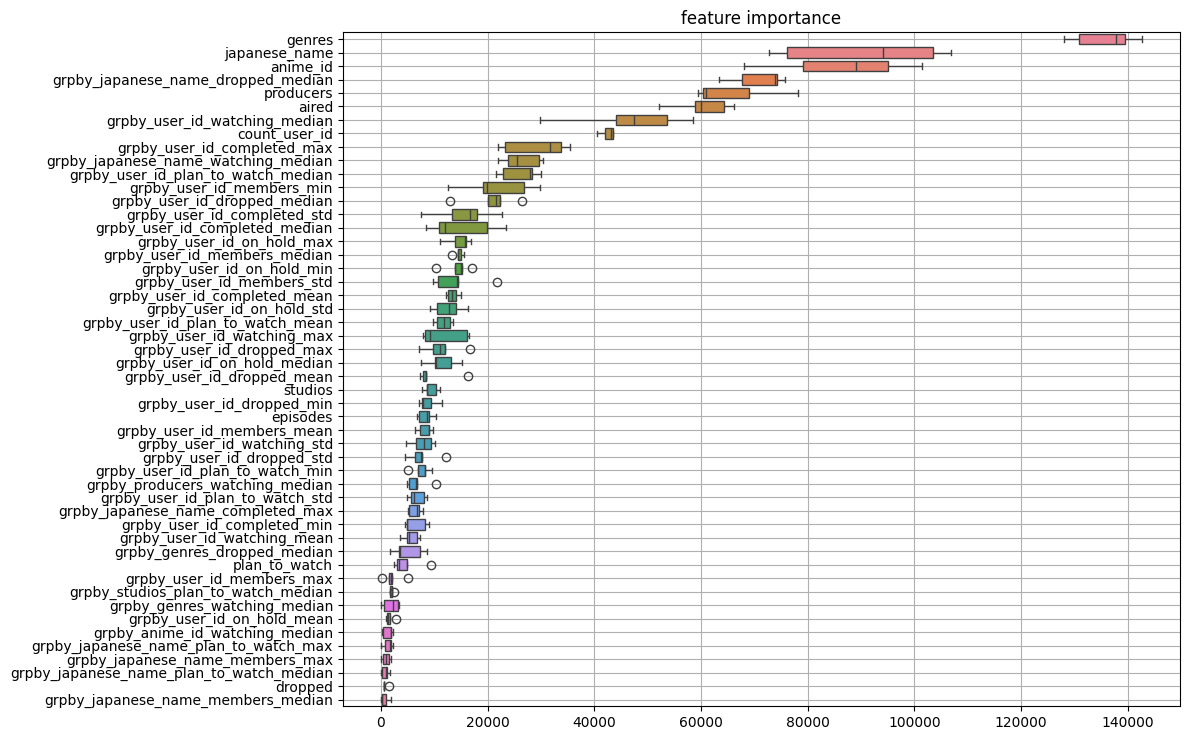

In [6]:
# 学習済みモデルから特徴量の重要度を取り出す
raw_importances = cvbooster.feature_importance(importance_type="gain")
importance_df = pd.DataFrame(data=raw_importances, columns=cvbooster.feature_name()[0])

# 平均値でソートする
sorted_indices = importance_df.mean(axis=0).sort_values(ascending=False).index
sorted_importance_df = importance_df.loc[:, sorted_indices]

# 上位をプロット -> 保存
plot_cols = sorted_importance_df.columns[:50]
fig, ax = plt.subplots(figsize=(12, max(3, len(plot_cols) * 0.15)))
sns.boxplot(data=sorted_importance_df[plot_cols], orient="h", ax=ax)
ax.grid()
ax.set_title("feature importance")
fig.tight_layout()
plt.show()
fig.savefig(f"{cfg.data.results_dir}/feature_importance.png")


### oof

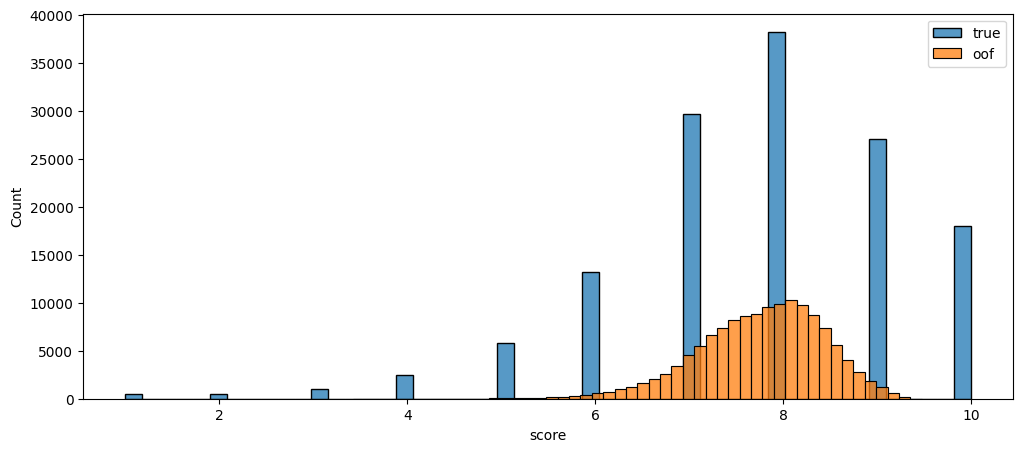

In [7]:
oof = np.zeros(len(x_train))

# 各fold毎に推論してoofを作成
for i, (_, valid_idx) in enumerate(kf.split(x_train, y_train, groups=groups)):
    x_valid = x_train.iloc[valid_idx]
    model = cvbooster.boosters[i]
    y_pred = model.predict(x_valid, num_iteration=cvbooster.best_iteration)
    oof[valid_idx] = y_pred

oof_df = pd.DataFrame({"oof": oof})
oof_df.to_csv(f"{cfg.data.results_dir}/oof.csv", index=False)

fig, ax = plt.subplots(figsize=(12, 5))
sns.histplot(y_train, bins=50)
sns.histplot(oof, bins=50)
plt.legend(["true", "oof"])
plt.show()
fig.savefig(f"{cfg.data.results_dir}/oof_hist.png")


### Submission

In [8]:
# 推論
x_test = test_df.drop(["user_id"], axis=1)
y_preds = cvbooster.predict(x_test, num_iteration=cvbooster.best_iteration)
y_pred = np.mean(y_preds, axis=0)

# 提出用ファイル作成
sub_df = pd.read_csv(cfg.data.sample_submission_path)
sub_df[cfg.target] = y_pred
sub_df.to_csv(f"{cfg.data.results_dir}/{cfg.run_name}_submission.csv", index=False)
sub_df.head()


,score
0,8.504159
1,8.741146
2,7.330998
3,8.183497
4,6.549899
